In [2]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
import sys, collections

### Preprocessing

Depending on which transcriptome you used, you will need to create a file translating transcripts to genes. This notebook assumes the file is in `tr2g`, for ensembl transcriptomes these can be generated using biomart.

The general format of `tr2g` is

~~~
ENST00000632684.1	ENSG00000282431.1
ENST00000434970.2	ENSG00000237235.2
ENST00000448914.1	ENSG00000228985.1
ENST00000415118.1	ENSG00000223997.1
ENST00000631435.1	ENSG00000282253.1
ENST00000390583.1	ENSG00000211923.1
ENST00000390577.1	ENSG00000211917.1
ENST00000451044.1	ENSG00000227108.1
ENST00000390578.1	ENSG00000211918.1
ENST00000390572.1	ENSG00000211912.1
...
~~~

The `matrix.ec` is generated by kallisto and connects the equivalence class ids to sets of transcripts. The format looks like

~~~
0	0
1	1
2	2
3	3
4	4
5	5
6	6
7	7
8	8
9	9
...
884398	26558,53383,53384,69915,69931,85319,109252,125730
884399	7750,35941,114698,119265
884400	9585,70083,92571,138545,138546
884401	90512,90513,134202,159456
884402	1460,2590,3476,8815,13440,13697,14581,18220,21799,21979,22752,23643,24268,31594,32066,32706,33922,33923,36234,40850,40851,49249,49250,50652,50989,51000,52533,54412,55545,56073,63432,63450,63457,63851,68524,70245,70679,70680,71800,77031,77202,77220,77867,92243,92749,92750,93617,96802,97437,98758,101367,109524,109838,113841,115937,116847,118451,118452,118984,118985,119680,121905,123916,125353,126987,127922,130003,130004,131999,132000,132001,132007,132008,132009,140512,140513,140514,144489,146571,150247,151565,151568,151571,151595,156609,156610,157764,157767,157773,157774,158578,166118,166119,169683,171534,171827,180225,184098
884403	83351,110474,110475,110476,110477,110478,110479,110480,110481,110482,174343
884404	22621,28045,37997,138681
884405	44088,44090,91875,91877,91878,91880,91884,91885,91887,91889,91894
884406	1232,1233,1234,1235,2387,2607,2608,7065,7066,7557,8638,8639,10905,11325,16266,21046,21047,21067,25410,25744,28980,29580,31453,31458,34886,35602,40319,45613,50352,55194,59781,62351,67708,71290,73284,76084,77412,77438,86173,86667,86669,86670,92243,110230,111434,116044,116847,123754,123756,123759,123892,123893,125169,129842,146226,146228,146571,149048,149949,151776,152059,153555,158139,160814,161642,162562,162591,165275,165276
884407	255,256,22621,33321,34387,37997,50333,53546,91651,96693,96706,121514,132702,138014,138681,140270,142596,169857
~~~

In [4]:
#load transcript

tr2g = {}
trlist = []
with open('data/tr2g') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('data/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

### Processing the BUS file

For this notebook we will work with the text file that `BUStools` produces, rather than the raw `BUS` file.

We discard any barcodes that don't have more 10 UMIs 

In [5]:
# load test dataset

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('data/output.sorted.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]



In [6]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s
    

In [7]:
whitelist = set(x.strip() for x in open('10xwhitelist.txt'))

3609


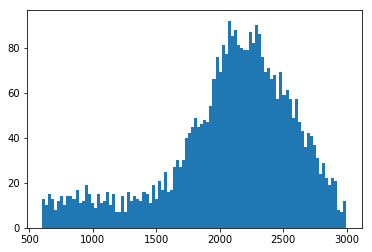

In [20]:
bcv = [x for b,x in barcode_hist.items() if x > 600 and x < 3000   and b in whitelist]
_ = plt.hist(bcv,bins=100)
print(len(bcv))

In [14]:
bad_barcode = [x for x in barcode_hist if  barcode_hist[x] <= 100]
len(bad_barcode)/len(cell_gene)

0.9375892828799086

In [15]:
s = 0
bad_s = 0
bad_barcode_set = set(bad_barcode)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    cgs =  sum(cg[g] for g in cg)
    s += cgs
    if barcode in bad_barcode_set:
        bad_s += cgs
    

In [16]:
bad_s/s

0.18355898685976038

## Export to Seurat compatible matrices

In [17]:
outfile = 'matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 600 and x < 3000 and b in whitelist]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])



In [18]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))
    

In [19]:
gene_names = {}
with open('mart_export.txt') as f:
    f.readline()
    for line in f:
        g,t,gn = line.split()
        gene_names[g] = gn


In [20]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('barcodes.tsv','w') as of:
    of.write('\n'.join(x + '-1' for x in barcodes_to_use))
    of.write('\n')

In [ ]:
gl[:10]